## loading the trained attribute classifier and running it on whole lfw 

In [ ]:
def initialize_lfw():
    # output_file_path = "../../data/attribute classifier/lfw/"
    global output_file_path, output_low_level_path, df_attributes
    output_file_path = "/content/drive/MyDrive/project-sepnu/data/neural network/"
    output_low_level_path = '/content/drive/MyDrive/project-sepnu/data/low level/lfw/'
    # output_low_level_path = "../../data/low level/lfw/"
    map_attributes_features_path ="/content/drive/MyDrive/project-sepnu/data/attribute classifier/lfw/map_attributes_features.txt"
    attributes_path = "/content/drive/MyDrive/LFW/metadata/modified_attributes.txt"
    if not os.path.exists(map_attributes_features_path):
        file_attributes = open(attributes_path, "r"); file_map_attributes_features = open(map_attributes_features_path, "w")
        for attribute in file_attributes.readline().replace("\n", "").split(",")[2:]: file_map_attributes_features.write(attribute + ":" + input("Enter space separated features for the attribute \"%s\": " % (attribute, )) + "\n")
        file_attributes.close(); file_map_attributes_features.close()
    file_map_attributes_features = open(map_attributes_features_path, "r")
    global map_attributes_features 
    map_attributes_features = {}
    for attribute, features in [line.split(":") for line in file_map_attributes_features.readlines()]:
        map_attributes_features[attribute] = features.split()
    file_map_attributes_features.close()
    df_attributes = pd.read_csv(attributes_path)
    file_images_under_error = open(output_low_level_path + "images_under_error.txt", "r")
    while True:
        line = file_images_under_error.readline().replace("\n", "")
        if line == "": break
        line = line.split()[0]
        matched_pattern = re.match(r"^([\w-]+?)_(\d+).jpg$", line[line.rindex("/")+1:])
        name, image_num = matched_pattern.groups()
        name = name.replace("_", " ")
        image_num = int(image_num)
        initial_shape = df_attributes.shape
        df_attributes.drop(df_attributes[(df_attributes['person'] == name) & (df_attributes['imagenum'] == image_num)].index, inplace = True)
        final_shape = df_attributes.shape
        assert (final_shape[0] + 1, final_shape[1]) == initial_shape
    file_images_under_error.close()
    assert df_attributes.shape[0] == np.load(output_low_level_path + "rgb_chin.npy").shape[0]
    


In [ ]:
class lfwData(Dataset):
    def __init__(self,data_list,attribute,transform=None,train=True):
        super().__init__()
        global map_attributes_features
        self.data_list = data_list
        # self.data_dir = data_dir
        self.transform = transform
        self.train = train
        # self.df_attr = df_attributes
        self.map_attr = df_attributes.columns.tolist().index(attribute)

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,item):
        global output_file_path, output_low_level_path, df_attributes
        # print(item)
        img_idx = item
        p1feature = []
        imgname = self.data_list[item]
        foldername = imgname[:-9]
        imgpath = os.path.join('/content/drive/MyDrive/LFW/zipped/lfw',foldername,imgname)
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        imgr = cv2.resize(img,(256,256))
        label = df_attributes.iloc[img_idx,self.map_attr]
        label = max(label,0)
        # p1feature = np.array(p1feature)
        if self.transform is not None:
            imgr = self.transform(imgr)
        if self.train:
          return {
              'img' : imgr,
              'label' : torch.tensor(label)
          }
        else:
          return {
              'img':imgr
          }
        

In [ ]:
def get_datalist(df):
    # df = df_attributes
    lfwnames = df['person'].tolist()
    lfwnames_nums = df['imagenum'].tolist()
    lfwnames_act = []
    for i in range(len(lfwnames)):
        num = '{0:04}'.format(lfwnames_nums[i])
        lfwnames_act.append(lfwnames[i].replace(" ","_") + "_" + num + ".jpg")
    assert len(lfwnames_act) == df.shape[0]
    return lfwnames_act

initialize_lfw()
# print(df_attributes.head())
data_list = get_datalist(df_attributes)

13014


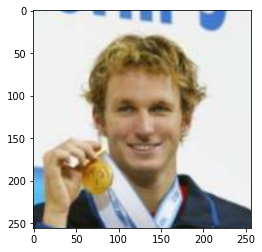

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3166, 0.3947, 0.4725), (0.1755, 0.1720, 0.1657)),
])
# transform = transforms.ToTensor()
train_data = lfwData(data_list,"Male")
print(len(train_data))
tem = train_data.__getitem__(3)
tem["img"].shape
plt.imshow(tem["img"])
# print(map_attributes_features.keys())

### using a dummy attribute just to use the previously made dataloader

In [ ]:
test_data = lfwData(data_list,"Male",transforms_train,False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
len(test_data)

13014

## loading the model

In [ ]:
class ResnetModel(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
considered_attr = 40
attr_model = ResnetModel(considered_attr).to(device)
attr_model.load_state_dict(torch.load("/content/drive/MyDrive/project-sepnu/data/neural network/attr_net_75k_40.pth"))

<All keys matched successfully>

In [ ]:
attr_model.eval()
from tqdm.notebook import tqdm
attr_preds = []
with torch.no_grad():
    for images in tqdm(test_loader):
        data = images['img'].squeeze(0).to(device)
        outputs = attr_model(data)
        # _, predicted = torch.max(outputs.data, 1)
        pr = outputs.detach().cpu().numpy()
        # print(pr)
        for i in pr:
          attr_preds.append(i)  

In [ ]:
def get_resnet():
    model1 = models.resnet50(pretrained=True)
    for name, child in model1.named_children():
        for param in child.parameters():
            param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model1.fc.in_features
    model1.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, 36)
    )
    return model1
# model = model1.to(device)

In [ ]:
simile_model = get_resnet().to(device)
simile_model.load_state_dict(torch.load("/content/drive/MyDrive/project-sepnu/data/neural network/simile_model.pth"))

<All keys matched successfully>

In [ ]:
simile_model.eval()
from tqdm.notebook import tqdm
simile_preds = []
with torch.no_grad():
    for images in tqdm(test_loader):
        data = images['img'].squeeze(0).to(device)
        outputs = simile_model(data)
        # _, predicted = torch.max(outputs.data, 1)
        pr = outputs.detach().cpu().numpy()
        # print(pr)
        for i in pr:
          simile_preds.append(i) 



In [ ]:
with open("/content/drive/MyDrive/project-sepnu/data/neural network/simile_prediction.pkl","wb") as f:
    pickle.dump(simile_preds,f)

In [ ]:
import pickle
with open("/content/drive/MyDrive/project-sepnu/data/neural network/attr_prediction.pkl","wb") as f:
    pickle.dump(attr_preds,f)

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
import re
import pickle
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
with open("/content/drive/MyDrive/project-sepnu/data/neural network/attr_prediction.pkl","rb") as f:
    attr_preds = pickle.load(f)
with open("/content/drive/MyDrive/project-sepnu/data/neural network/simile_prediction.pkl","rb") as f:
    simile_preds = pickle.load(f)

attr_preds = np.array(attr_preds)
simile_preds = np.array(simile_preds)
print(attr_preds.shape)
print(simile_preds.shape)
combined_preds = np.concatenate((attr_preds,simile_preds),axis=1)
print(combined_preds.shape)

(13014, 40)
(13014, 36)
(13014, 76)


In [ ]:
# pairindexes contains a list containing a bunch of [index1, index2]
def genPairIndexes_lfw(attrPath = '/content/drive/MyDrive/LFW/metadata/modified_attributes.txt', genLabels = 0):
    global df_attributes
    df_attributes = pd.read_csv(attrPath, delimiter = ",")
    output_low_level_path = '/content/drive/MyDrive/project-sepnu/data/low level/lfw/'
    file_images_under_error = open(output_low_level_path + "images_under_error.txt", "r")
    while True:
        line = file_images_under_error.readline().replace("\n", "")
        if line == "": break
        line = line.split()[0]
        matched_pattern = re.match(r"^([\w-]+?)_(\d+).jpg$", line[line.rindex("/")+1:])
        name, image_num = matched_pattern.groups()
        name = name.replace("_", " ")
        image_num = int(image_num)
        initial_shape = df_attributes.shape
        df_attributes.drop(df_attributes[(df_attributes['person'] == name) & (df_attributes['imagenum'] == image_num)].index, inplace = True)
        final_shape = df_attributes.shape
        assert (final_shape[0] + 1, final_shape[1]) == initial_shape
    file_images_under_error.close()
    assert df_attributes.shape[0] == np.load(output_low_level_path + "rgb_chin.npy").shape[0]

    df = df_attributes
    lfwnames = df['person'].tolist()
    lfwnames_nums = df['imagenum'].tolist()
    lfwnames_act = []
    for i in range(len(lfwnames)):
        num = '{0:04}'.format(lfwnames_nums[i])
        lfwnames_act.append(lfwnames[i].replace(" ","_") + "_" + num + ".jpg")
    file_images_under_error = open(output_low_level_path + "images_under_error.txt", "r")

    with open("/content/drive/MyDrive/project-sepnu/src/verification /dataset.pkl", "rb") as input_file:
        datalist = pickle.load(input_file)

    pairIndexes = []
    labels = [] 
    err_names = {'dummy.jpg'}
    for first_person,second_person,label in datalist:
        first_person = first_person.split("/")[2]
        second_person = second_person.split("/")[2]
        if first_person not in lfwnames_act :
            # print(first_person, "not in list")
            err_names.add(first_person)
        elif second_person not in lfwnames_act:
            # continue
            # print(second_person, "not in list")
            err_names.add(second_person)
        else:
            # print(lfwnames_act.index(first_person), lfwnames_act.index(second_person))
            pairIndexes.append([lfwnames_act.index(first_person), lfwnames_act.index(second_person)])
            if label == 0:
                labels.append(-1)
            else:
                labels.append(1)
    # for i in range(10):
    # print(err_names)
        # print(pairIndexes[i])
    if genLabels:
        return pairIndexes, err_names, labels
    else:
        return pairIndexes, err_names

In [ ]:
pairs,errdict,labels = genPairIndexes_lfw(genLabels=1)
len(pairs)


6143

In [ ]:
print(min(combined_preds[1]))

-24.064976


In [ ]:
final_dataset = []
for p1,p2 in pairs:
    feature = np.hstack((combined_preds[p1],combined_preds[p2]))
    final_dataset.append(feature)

final_dataset = np.array(final_dataset)
print(final_dataset.shape)
final_dataset_labels = []


for i in range(len(final_dataset)):
    feat_label = {}
    feat_label["img"] = torch.tensor(final_dataset[i])
    feat_label["label"] = torch.tensor(labels[i])
    final_dataset_labels.append(feat_label)

# final_dataset_labels.__getitem__(2)


(6143, 152)


In [ ]:
class VerifNet(nn.Module):
    def __init__(self, tot_inputs):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(tot_inputs, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
        )
        self.tan = nn.Tanh()

    def forward(self, x):
        x = self.classifier(x)        
        return self.tan(x)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:

model = VerifNet(152).to(device)
xrand = torch.rand((32,152)).to(device)
print(xrand.shape)
y = model(xrand)
print(xrand)
print(y)

torch.Size([32, 152])
tensor([[0.6344, 0.8908, 0.8086,  ..., 0.3675, 0.9570, 0.0579],
        [0.0955, 0.5808, 0.2345,  ..., 0.7818, 0.1673, 0.4550],
        [0.9958, 0.7860, 0.0892,  ..., 0.4504, 0.7627, 0.1348],
        ...,
        [0.9555, 0.5827, 0.5972,  ..., 0.1342, 0.6674, 0.6891],
        [0.6144, 0.0887, 0.1945,  ..., 0.2499, 0.0312, 0.9795],
        [0.1609, 0.2558, 0.0284,  ..., 0.0731, 0.3480, 0.7270]],
       device='cuda:0')
tensor([[0.0178],
        [0.0356],
        [0.0329],
        [0.0288],
        [0.0243],
        [0.0293],
        [0.0148],
        [0.0333],
        [0.0267],
        [0.0220],
        [0.0107],
        [0.0357],
        [0.0173],
        [0.0225],
        [0.0215],
        [0.0332],
        [0.0187],
        [0.0264],
        [0.0238],
        [0.0249],
        [0.0342],
        [0.0276],
        [0.0195],
        [0.0278],
        [0.0175],
        [0.0163],
        [0.0186],
        [0.0213],
        [0.0207],
        [0.0168],
        [0.0224]

In [ ]:
from tqdm.notebook import tqdm
def train_test(data_list):
    # full_dataset = CustomData(transforms,train_path,trainimgs)
    print("=========================================================================================")
    print("=========================================================================================")
    full_dataset = data_list
    train_size = int(0.8 * len(full_dataset)) 
    test_size = len(full_dataset) - train_size

    batch = 16
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

    model = VerifNet(152).to(device)
    optimizer = optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss().to(device)
    num_epochs = 15
    valid_loss_min = np.Inf

    losses = {'train' : [] } 
    accuracies = {'train' : []} 
    dataloaders = {
        'train':train_loader,
        'test':test_loader
    }
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        model.train()
        # for phase in ['train']:

        curr_loss = 0.0
        curr_acc = 0

        for dinputs in dataloaders["train"]:
            print(dinputs["img"].shape)
            inputs = dinputs["img"].to(device)
            labels = dinputs["label"].to(device)

            outputs = model(inputs)
            print("output.shape",outputs.shape)
            print("labels.shape",labels.shape)
            # print("inputs.shape",inputs.shape)
            labels = torch.reshape(labels, outputs.shape)
            print("output.shape",outputs.shape)
            print("labels.shape",labels.shape)
            # print("inputs.shape",inputs.shape)
            # print("output.shape",output.shape)
            return
            loss = error(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            curr_loss += loss.item() * inputs.size(0)
            curr_acc += torch.sum(preds == labels.data)

        curr_loss = curr_loss / len(dataloaders["train"].sampler)
        curr_acc = curr_acc.double() / len(dataloaders["train"].sampler)
        
        losses["train"].append(curr_loss)
        accuracies["train"].append(curr_acc)
        # if epoch == num_epochs - 1:
        print("train" + ":")
        print('loss = {:.4f}     accuracy = {:.4f}'.format(curr_loss,curr_acc))
            # print()
        # train_losses.append(train_loss)
        # valid_losses.append(valid_loss)

    '''
    test code here
    '''
    model.eval()
    test_loss = 0.0
    test_acc = 0
    for dinputs in dataloaders["test"]:
        inputs = dinputs["img"].to(device)
        labels = dinputs["label"].to(device)

        outputs = model(inputs)
        loss = error(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(preds == labels.data)

    test_loss = test_loss / len(dataloaders["test"].sampler)
    test_acc = test_acc.double() / len(dataloaders["test"].sampler)
    print("test" + ":")
    print("loss: {:.4f}     accuracy: {:.4f}".format(test_loss, test_acc))

    return losses,accuracies    

In [ ]:
loss,acc = train_test(final_dataset_labels)

Epoch 1/15
----------
torch.Size([16, 152])
output.shape torch.Size([16, 1])
labels.shape torch.Size([16])
output.shape torch.Size([16, 1])
labels.shape torch.Size([16, 1])


TypeError: ignored